### Analyse des prédictions IG sans entrainement sur ce type de cellule

> Utilise modèle entrainésur les 7 autres types de cellules et évaluation de la classification des IG afin d'identifier les caractéristiques communes utilisées

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

import gradcam

In [2]:
#Charge le modèle VGG16 entrainé sur les 8 dernières couches
model = load_model('vgg16_no_ig_fine_tunning')

In [3]:
src_img = '../images_mendeley/dataset_redim/'

#### Récupération des images IG

In [4]:
data = pd.read_csv('../mendeley_cells_redim.csv',index_col=0)
# Uniquement les images IG
data_IG = data[data['category']=='ig']


In [5]:
# ImageDataGenerator pour éviter de charger les images en mémoire
# Shuffle à false, pour récupérer les classes correspondantes
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
ig_generator = data_generator.flow_from_dataframe(data_IG, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32,shuffle=False)

Found 2895 validated image filenames belonging to 1 classes.


#### Prédiction sur les IG => cf les pourcentage

In [8]:
predict = model.predict(ig_generator)

In [6]:
lst_classes = [key for key, val in ig_generator.class_indices.items()]

In [9]:
lst_classes = ['basophil','eosinophil','erythroblast','lymphocyte','monocyte','neutrophil','platelet']
pourcentage = pd.DataFrame(predict.round(2), columns=lst_classes)

In [10]:
pourcentage.describe()

,basophil,eosinophil,erythroblast,lymphocyte,monocyte,neutrophil,platelet
count,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000
mean,0.195537,0.010387,0.053813,0.020888,0.480034,0.232640,0.005689
std,0.340200,0.069355,0.177477,0.109801,0.427343,0.376782,0.048312
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.420000,0.000000,0.000000
75%,0.210000,0.000000,0.000000,0.000000,0.970000,0.355000,0.000000
max,1.000000,0.990000,1.000000,1.000000,1.000000,1.000000,0.980000


In [11]:
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]

In [12]:
predictions = pd.DataFrame(eval_predict_class_name, columns=['Prédictions'])

#### Répartition

In [13]:
predictions['Prédictions'].value_counts()

monocyte        1403
neutrophil       680
basophil         580
erythroblast     151
lymphocyte        53
eosinophil        19
platelet           9
Name: Prédictions, dtype: int64

>Presque la moitié des images sont prédites en monocyte, 20% en neutrophil et 20% en basophil.
>
>La prédiction en neutrophil et basophil était attendu : les IG étant des cellules immatures de types neutrophil, basophil et eosinophil.
>    
>Cependant le classement en monocyte pose question : caractéristiques communes identifiées sur ces 2 types de cellules.


### GRAD CAM

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1799      
Total params: 15,897,927
Trainable params: 15,897,927
Non-trainable params: 0
____________________________________________

In [25]:
# Reconstruit le modèle car problème de base_model avec GradCam
base_model = model.layers[0]
x = base_model.output
x = model.get_layer('global_average_pooling2d')(x)
x = model.get_layer('dense')(x)
x = model.get_layer('dense_1')(x)
x = model.get_layer('dense_2')(x)
x = model.get_layer('dense_3')(x)
model_gradcam = Model(inputs = base_model.input, outputs = x)

In [26]:
img_size = (224, 224)
last_conv_layer_name = "block5_conv3"

##### IG prédite en basophil

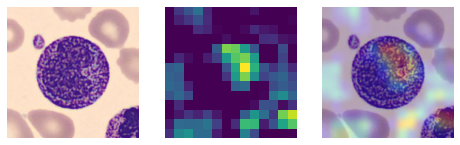

In [73]:
gradcam.display_headmap(preprocess_input, src_img +'N_PMY_988901.jpg', img_size, model_gradcam, last_conv_layer_name)

> Prise en compte de caractéristiques en dehors de la cellule et seulement une petite partie de la cellule

##### IG prédite en eosinophil

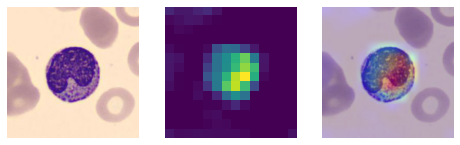

In [29]:
gradcam.display_headmap(preprocess_input, src_img+'N_MMY_100949.jpg', img_size, model_gradcam, last_conv_layer_name)

> Prise en compte du cytoplasme et noyau, mais le noyau devrait être segmenté pour un eosinophil

##### IG prédite en erythroblast

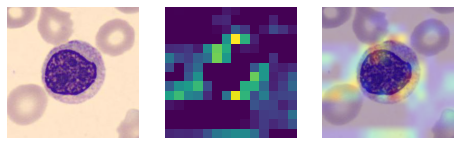

In [66]:
gradcam.display_headmap(preprocess_input, src_img + 'N_MY_975062.jpg', img_size, model_gradcam, last_conv_layer_name)

> Prise en compte de caractéristiques hors de la cellule, pas prise en compte du noyau

##### IG prédite en lymphocyte

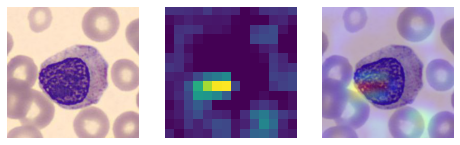

In [57]:
gradcam.display_headmap(preprocess_input, src_img + 'N_MY_785566.jpg', img_size, model_gradcam, last_conv_layer_name)

> Prend en compte uniquement le noyau similaire au lymphocyte, besoin des caractéristiques du cytoplasme pour différenciation

##### IG prédite en monocyte

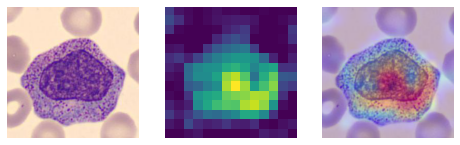

In [45]:
gradcam.display_headmap(preprocess_input, src_img + 'N_PMY_853430.jpg', img_size, model_gradcam, last_conv_layer_name)

> Taille de la cellule et du noyau similaire à monocyte, mais monocyte présente en plus des "trous" dans le cytoplasme

##### IG prédite en neutrophil

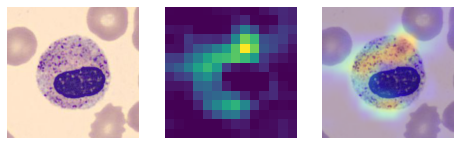

In [36]:
gradcam.display_headmap(preprocess_input, src_img + 'N_MMY_19855.jpg', img_size, model_gradcam, last_conv_layer_name)

> Prise en compte du cytoplasme, ici effectivement c'est une cellule métamyelocyte de type neurophil, donc le cytoplasme est similaire
>
> Il faudrait prendre également en compte le noyau qui est lui en non fragmenté contrairement au neutrophil

##### IG prédite en platelet

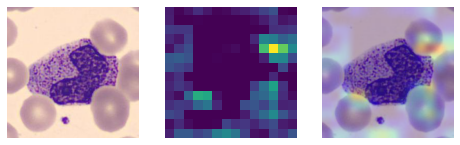

In [46]:
gradcam.display_headmap(preprocess_input, src_img + 'N_MMY_252383.jpg', img_size, model_gradcam, last_conv_layer_name)

> Prise en compte de caractéristiques en dehors de la cellule